# Simulation Playground Notebook
This notebook is designed as a easy einterface to call the functions that we have defined

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import load_participants_info, load_event_descriptions, load_behavioral_data, preprocess_data

# Data Preparation
Let's prepare some data first to fit our model. We are specifically using ["Locus coeruleus activity strengthens prioritized memories under arousal"](https://openneuro.org/datasets/ds002011/versions/1.0.0) dataset fror now.

In [2]:
DATASET_PATH = "data"
participants_df = load_participants_info(DATASET_PATH)
load_event_descriptions(DATASET_PATH)

df_behavior = load_behavioral_data(DATASET_PATH, "01")
for idx in range(2,11):
    sample_participant = f"0{idx}"
    df = load_behavioral_data(DATASET_PATH, sample_participant)
    df_behavior = pd.concat([df, df_behavior], ignore_index=True)

Let's preprocess our data first

In [3]:
X, Y, X_tensor, Y_tensor, scaler_X, scaler_Y, df_clean = preprocess_data(df_behavior)

X Shape: torch.Size([1699, 7]), Y Shape: torch.Size([1699])
Y Min: -1.0, Y Max: 1.0


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Training

In [5]:
from train import (train_feed_forward_nn,
                   train_vanilla_rnn,
                   train_vanilla_lstm,
                   train_vanilla_lc_model,
                   train_lstm_lc_model,
                   train_ff_controller
                   )
from analysis.evaluation import evaluate_model

## Fully Connected Neural Network

To illustrate our idea, we want to train 2 models from math and computer science, which is our vanilla feed forward networks and an recurrent networks.

Epoch 0, Loss: 0.08626092225313187
Epoch 100, Loss: 0.04716753214597702
Epoch 200, Loss: 0.045746810734272
Epoch 300, Loss: 0.04450536146759987
Epoch 400, Loss: 0.04298696666955948
Epoch 500, Loss: 0.04134441167116165
Epoch 600, Loss: 0.04005681350827217
Epoch 700, Loss: 0.03919363021850586
Epoch 800, Loss: 0.037868693470954895
Epoch 900, Loss: 0.03756232559680939
Epoch 1000, Loss: 0.036965589970350266
Epoch 1100, Loss: 0.036544572561979294
Epoch 1200, Loss: 0.0371435284614563
Epoch 1300, Loss: 0.03612267225980759
Epoch 1400, Loss: 0.035614725202322006
Epoch 1500, Loss: 0.03571926802396774
Epoch 1600, Loss: 0.0354684516787529
Epoch 1700, Loss: 0.03571195527911186
Epoch 1800, Loss: 0.0352102555334568
Epoch 1900, Loss: 0.03545920178294182
Training complete!
Evaluating Model: FeedForwardNN


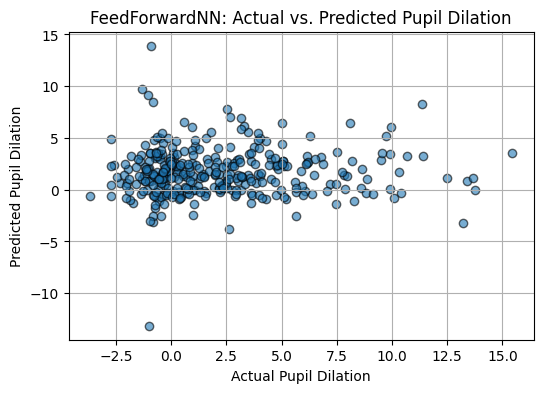

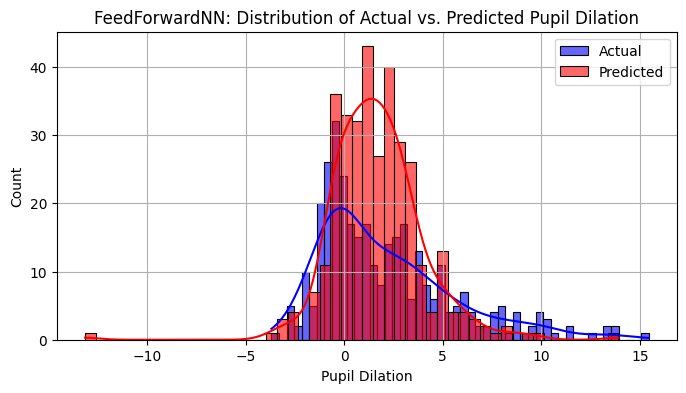

FeedForwardNN - Pearson Correlation: 0.0336


In [6]:
model_ff = train_feed_forward_nn(X_train, Y_train,epochs=2000)
evaluate_model(model_ff, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## Recurent Neural Networks

We will  do the same thing with an recurrent neural network

In [7]:
# model_rnn = train_vanilla_rnn(X_train, Y_train, epochs=2000)
# evaluate_model(model_rnn, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## LSTM Models

In [8]:
# model_lstm = train_vanilla_lstm(X_train, Y_train, epochs=5000, hidden_dim=12)
# evaluate_model(model_lstm, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## LCNECortex Fitter Model

Now coming to our customized LCNECortex model

Epoch 0, Loss: 0.21593184769153595
Epoch 100, Loss: 0.032070230692625046


/Users/kevinb/miniforge3/envs/cse251b/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 200, Loss: 0.03999152034521103
Epoch 300, Loss: 0.027544206008315086
Epoch 400, Loss: 0.020267626270651817
Epoch 500, Loss: 0.03300367295742035
Epoch 600, Loss: 0.02889593318104744
Epoch 700, Loss: 0.04036754369735718
Epoch 800, Loss: 0.04475291818380356
Epoch 900, Loss: 0.024170944467186928
Epoch 1000, Loss: 0.021557221189141273
Epoch 1100, Loss: 0.041841503232717514
Epoch 1200, Loss: 0.04031329229474068
Epoch 1300, Loss: 0.026058925315737724
Epoch 1400, Loss: 0.026033733040094376
Epoch 1500, Loss: 0.044320039451122284
Epoch 1600, Loss: 0.036109767854213715
Epoch 1700, Loss: 0.021183576434850693
Epoch 1800, Loss: 0.01706824079155922
Epoch 1900, Loss: 0.0285224299877882
Training complete!
Evaluating Model: LCNECortexFitter


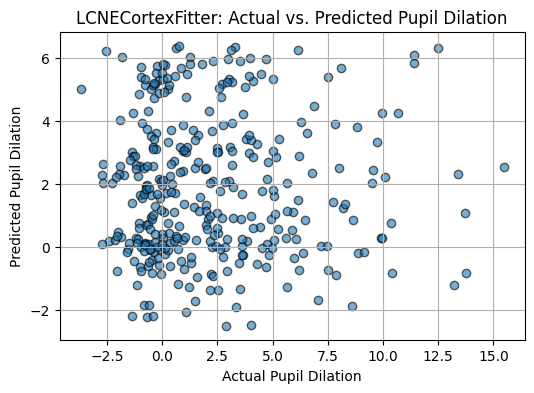

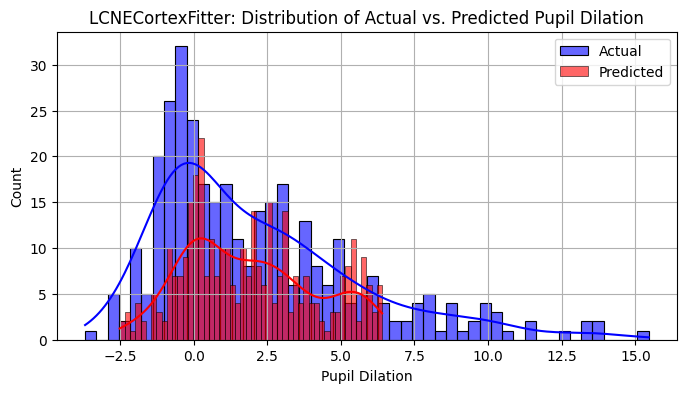

LCNECortexFitter - Pearson Correlation: 0.0033


In [9]:
model_lc_vanilla = train_vanilla_lc_model(X_train, Y_train, epochs=2000)
evaluate_model(model_lc_vanilla, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## LSTM LCNECortex Model

In [10]:
# model_lc_lstm = train_lstm_lc_model(X_train, Y_train, epochs=2000, hidden_dim=64)
# evaluate_model(model_lc_lstm, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

# FF Gadget Model

Epoch 0, Loss: 0.146209


/Users/kevinb/miniforge3/envs/cse251b/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 100, Loss: 0.028494
Epoch 200, Loss: 0.027509
Epoch 300, Loss: 0.050678
Epoch 400, Loss: 0.016514
Epoch 500, Loss: 0.034929
Epoch 600, Loss: 0.036484
Epoch 700, Loss: 0.030495
Epoch 800, Loss: 0.028988
Epoch 900, Loss: 0.026364
Epoch 1000, Loss: 0.021794
Epoch 1100, Loss: 0.022632
Epoch 1200, Loss: 0.032364
Epoch 1300, Loss: 0.026874
Epoch 1400, Loss: 0.015178
Epoch 1500, Loss: 0.027441
Epoch 1600, Loss: 0.019354
Epoch 1700, Loss: 0.045307
Epoch 1800, Loss: 0.014726
Epoch 1900, Loss: 0.027944
Epoch 2000, Loss: 0.025397
Epoch 2100, Loss: 0.041189
Epoch 2200, Loss: 0.012875
Epoch 2300, Loss: 0.017380
Epoch 2400, Loss: 0.023134
Epoch 2500, Loss: 0.055563
Epoch 2600, Loss: 0.016205
Epoch 2700, Loss: 0.023694
Epoch 2800, Loss: 0.016644
Epoch 2900, Loss: 0.025827
Epoch 3000, Loss: 0.023893
Epoch 3100, Loss: 0.025452
Epoch 3200, Loss: 0.029850
Epoch 3300, Loss: 0.023044
Epoch 3400, Loss: 0.020260
Epoch 3500, Loss: 0.013495
Epoch 3600, Loss: 0.019139
Epoch 3700, Loss: 0.030464
Epoch 3800

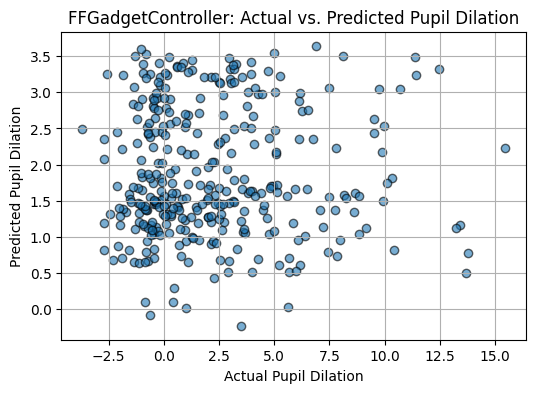

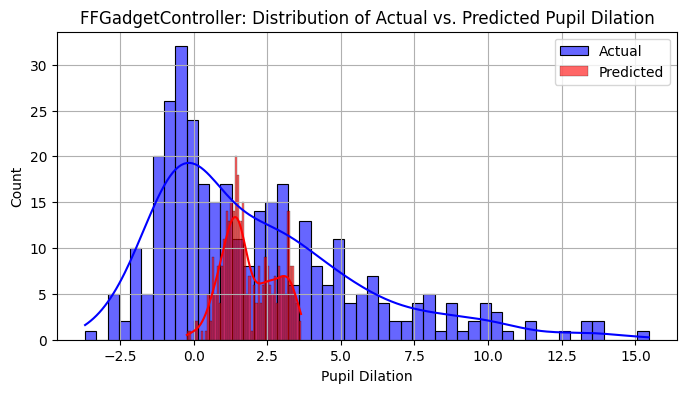

FFGadgetController - Pearson Correlation: 0.0134


In [11]:
ff_gadget = train_ff_controller(X_train, Y_train, epochs=5000, hidden_dim=200)
evaluate_model(ff_gadget, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

Interesting results

# Analysis

In [12]:
from analysis.analysis import (pca_lcne_lstm,
                               pca_feed_forward,
                               pca_lcne,
                               pca_lstm,
                               analyze_ff_gadget_activations,
)

## Feed-Forward Neural Networks

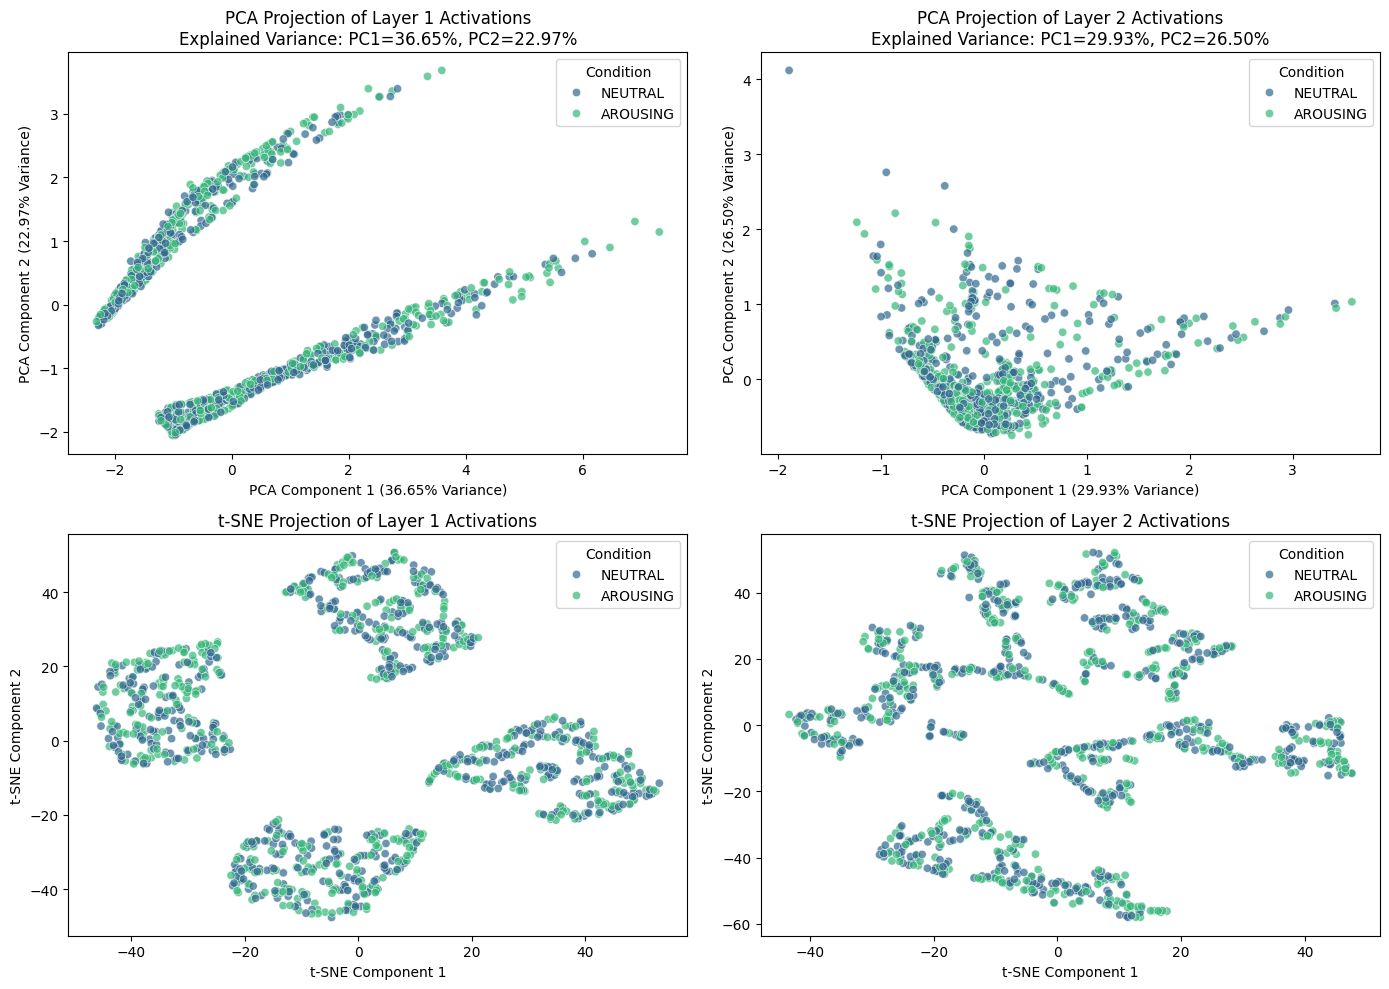

In [13]:
pca_feed_forward(model_ff, X_tensor, df_behavior)

## LCNECortex Model

We will see that, though  under fitted with the real data, there are some structureness to the data that we can play around with since we injected mechanistic insights into it.

Text(0.5, 1.0, 'Cortex Activation Distribution')

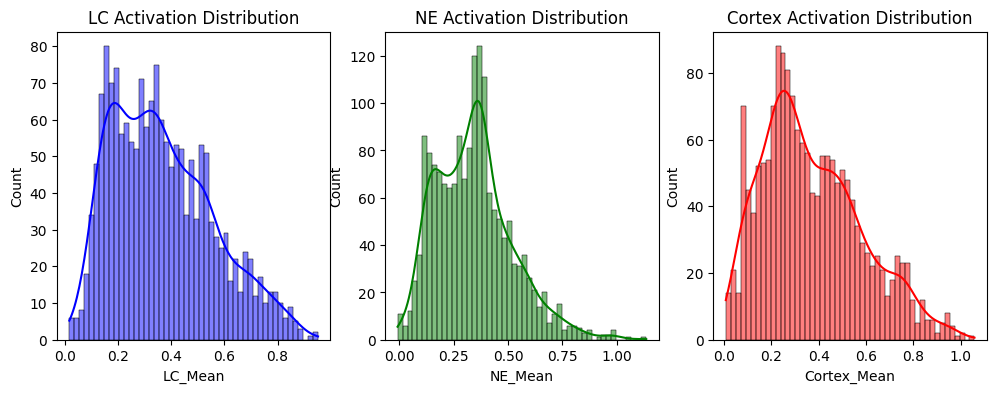

In [14]:
with torch.no_grad():
    prev_LC = torch.zeros(X_tensor.shape[0], model_lc_vanilla.hidden_dim)
    prev_Cortex = torch.zeros(X_tensor.shape[0], model_lc_vanilla.hidden_dim)

    LC_act, NE_act, C_act, Pupil_pred, LC_raw, NE_raw, C_raw = model_lc_vanilla(X_tensor, prev_LC, prev_Cortex, return_activations=True)

act_lc = LC_act.cpu().numpy()
act_ne = NE_act.cpu().numpy()
act_cortex = C_act.cpu().numpy()

df_activations = pd.DataFrame({
    'LC_Mean': act_lc.mean(axis=1),
    'NE_Mean': act_ne.mean(axis=1),
    'Cortex_Mean': act_cortex.mean(axis=1),
    'PupilPred': Pupil_pred.cpu().numpy().squeeze(),
    'ActualPupil': df_clean['Event_PupilDilation'].values  # Ensure this aligns with X_tensor
})

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df_activations['LC_Mean'], kde=True, bins=50, color='blue')
plt.title("LC Activation Distribution")

plt.subplot(1, 3, 2)
sns.histplot(df_activations['NE_Mean'], kde=True, bins=50, color='green')
plt.title("NE Activation Distribution")

plt.subplot(1, 3, 3)
sns.histplot(df_activations['Cortex_Mean'], kde=True, bins=50, color='red')
plt.title("Cortex Activation Distribution")

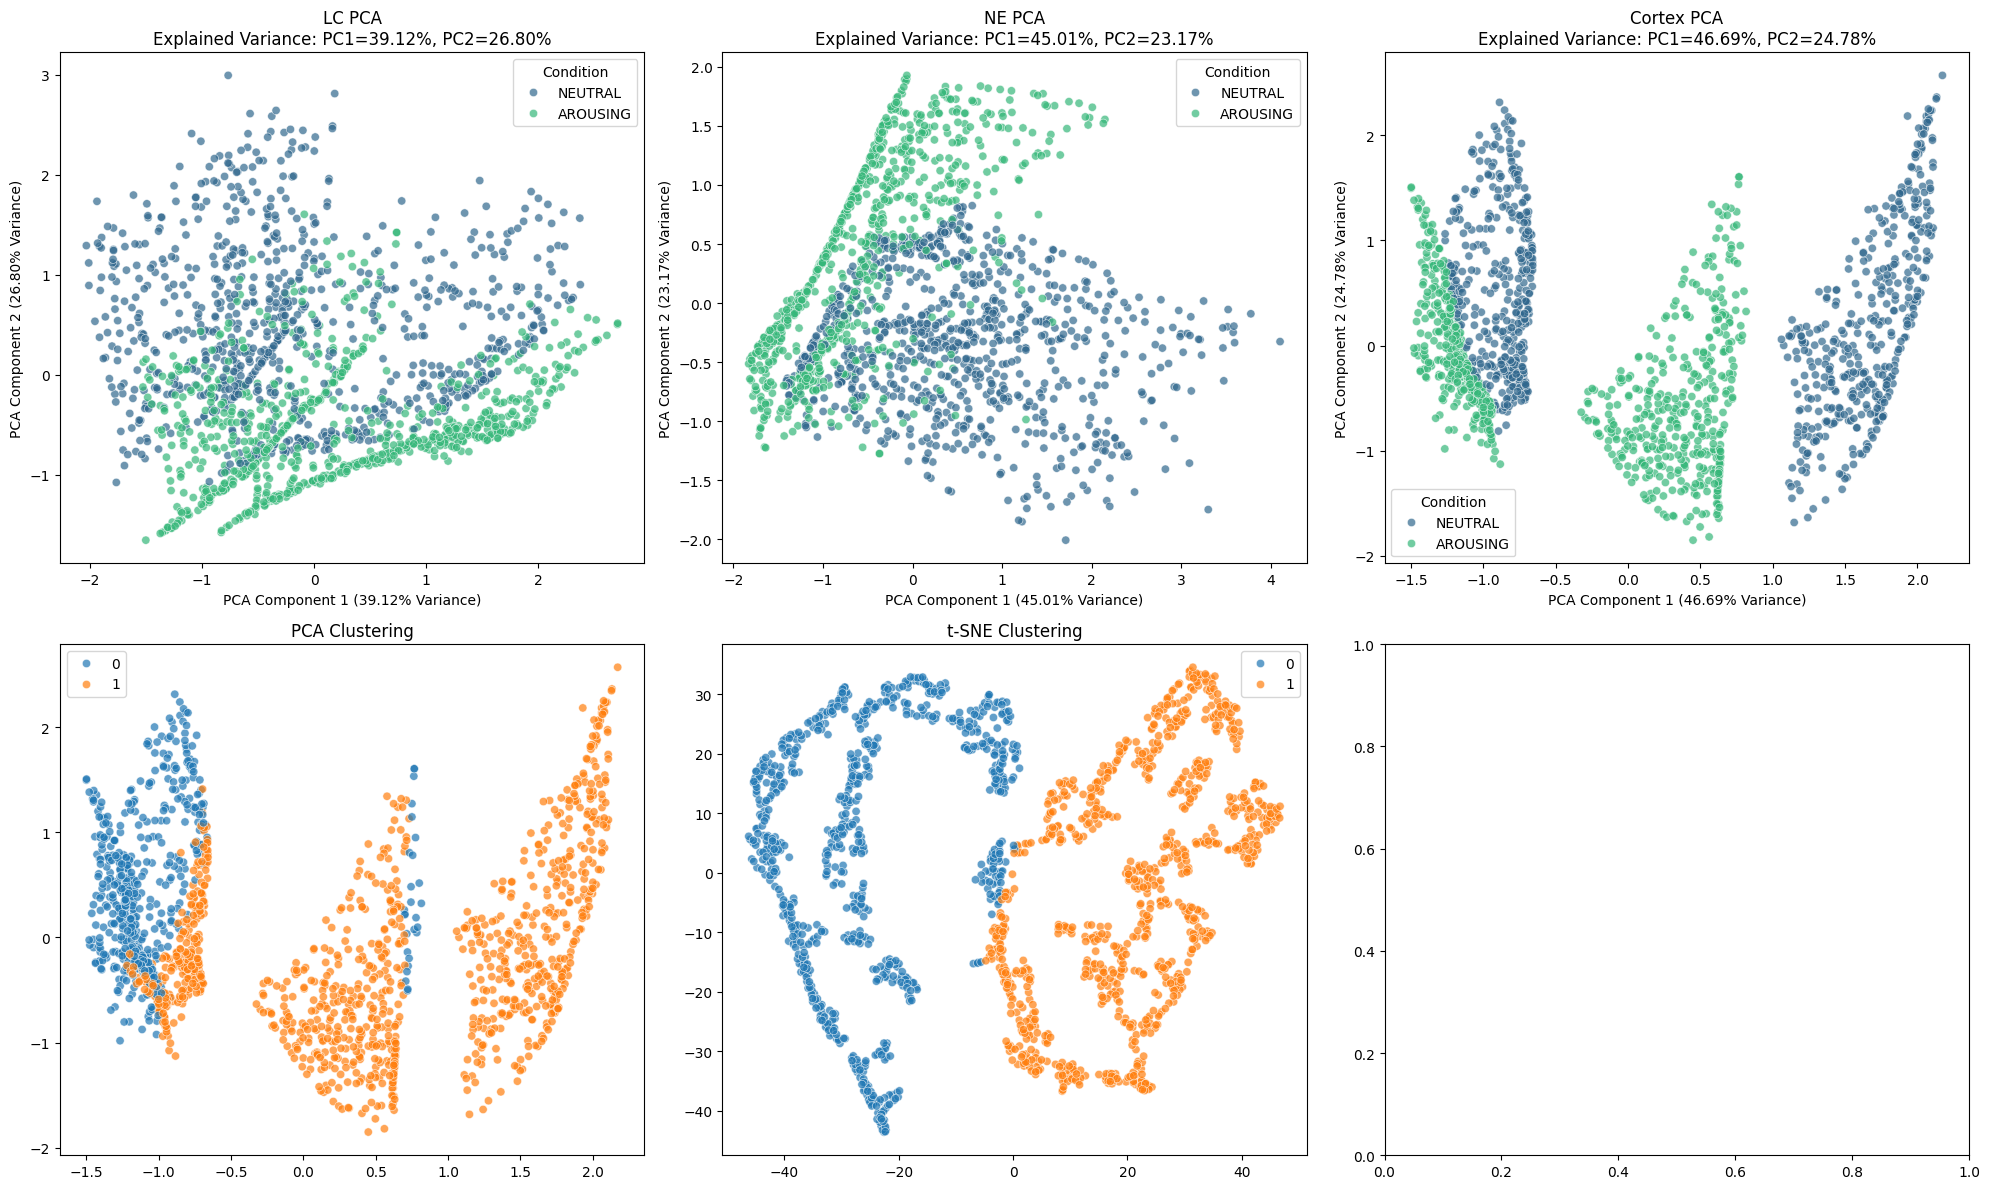

In [15]:
pca_lcne(model_lc_vanilla, X_tensor, df_clean)

## LSTM LCNECortex Model

In [16]:
# pca_lcne_lstm(model_lc_lstm, X_tensor, df_clean)

## Vanilla LSTM Comparison

In [17]:
# pca_lstm(model_lstm, X_test, df_clean)

## FF Gadget Model

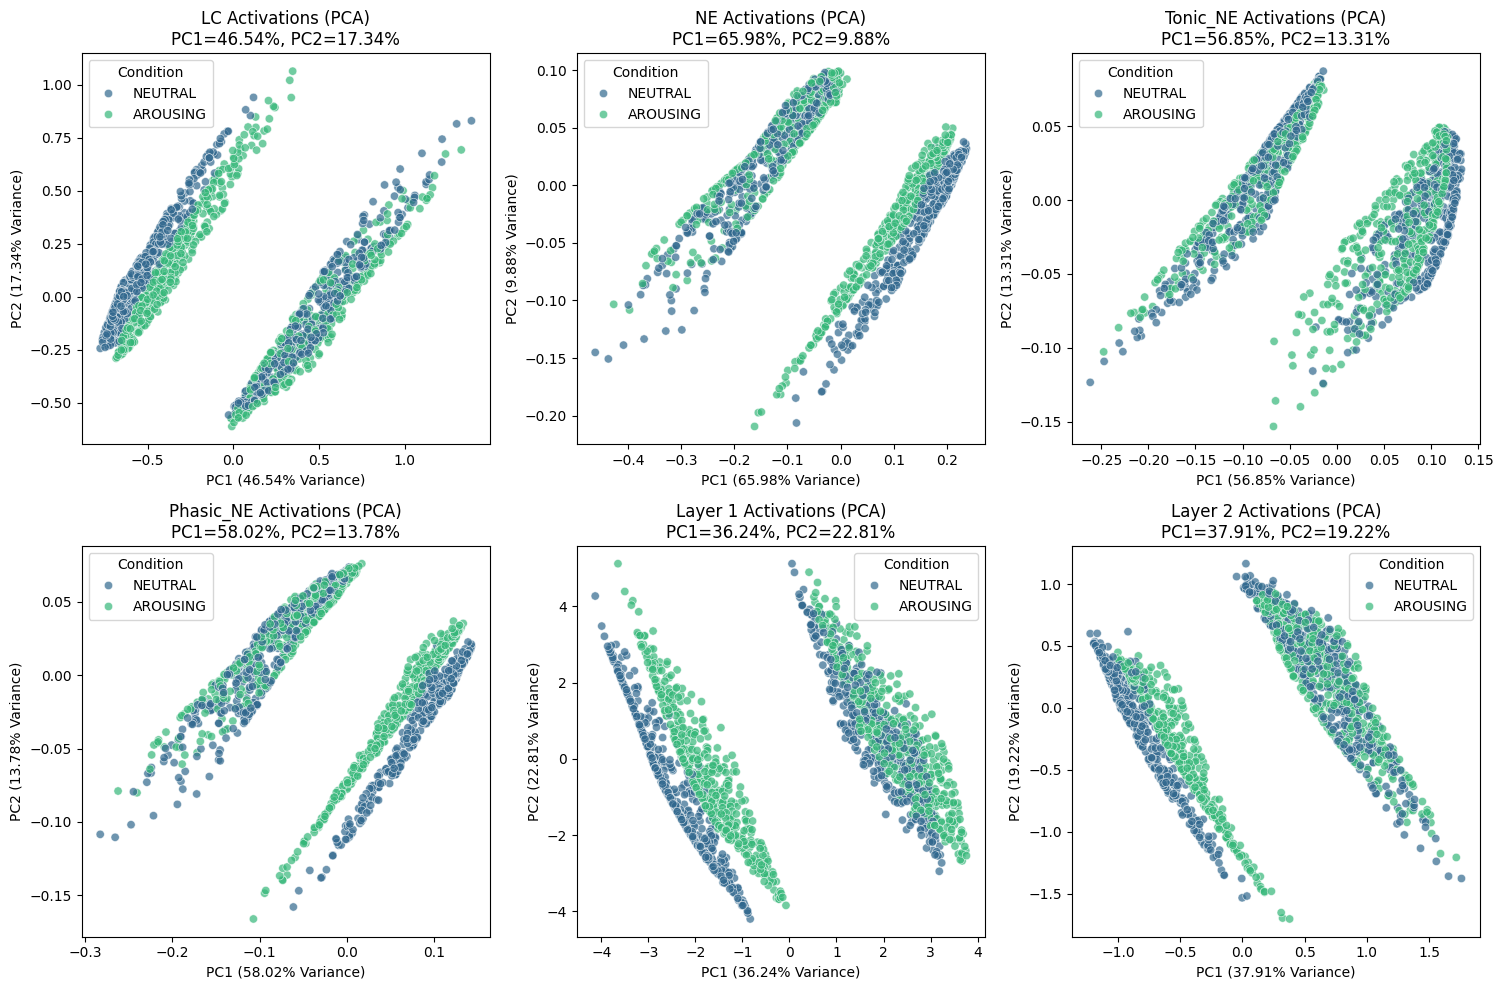


 Pearson Correlation with Actual Pupil Dilation:
LC: 0.156
NE: 0.359
Tonic_NE: 0.375
Phasic_NE: 0.339
Layer 1: -0.095
Layer 2: -0.177
Predicted Pupil Dilation: 0.444


In [18]:
analyze_ff_gadget_activations(ff_gadget, X_tensor, df_clean)